# 시험장 환경 정보

Python: 3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]

|모듈|버젼|
|----|----|
|pandas|0.25.1|
|numpy|1.18.5|
|sklearn|0.21.3|
|scipy|1.5.2|
|mlxtend|0.15.0.0|
|statsmodels|0.11.1|

In [1]:
# 실행 환경 확인

import pandas as pd
import numpy as np
import sklearn
import scipy
import statsmodels
import mlxtend
import sys

print(sys.version)
for i in [pd, np, sklearn, scipy, mlxtend, statsmodels]:
    print(i.__name__, i.__version__)

3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
pandas 1.3.5
numpy 1.21.5
sklearn 0.21.3
scipy 1.5.2
mlxtend 0.15.0.0
statsmodels 0.13.5


In [2]:
# 시각화 모듈 설정
# 참고용 차트를 출력하기 위함

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
import matplotlib.font_manager as fm
plt.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False

# 문제 개요

다음은 폴더블 폰의 힌지에 들어가는 스프링 내구력을 테스트한 실험 결과이다. 

스프링 측정값과 스프링에 가한 부하 정보와 함께, 테스트 통과/실패 (failure) 결과가 기재되어 있다. 

개발부서는 테스트 비용을 줄이기 위해 failure 여부를 맞추는 모델을 만들고자 한다.

변수명은 보안을 위해 measurement_0과 같이 익명화되었다.

데이터 구성

학습데이터: train_prob.csv, 21,458 rows, 25 columns

테스트데이터: test_prob.csv, 5,112 rows, 24 columns, 

테스트정답셋: test_prob_ans.csv, 5,112 rows, 1 columns


컬럼명	설명	타입

|변수명|설명|타입|
|--|--------------|------|
|id|실험 고유 번호|정수형|
|product_code|스프링 코드|범주형|
|loading|스프링에 가한 부하|실수형|
|attribute_0|구성 소재1|범주형|
|attribute_1|구성 소재2|범주형|
|attribute_2|구성 소재3|정수형|
|attribute_3|구성 소재4|정수형|
|measurement_0 ~ 17|측정값 0~17|실수형|
|failure|성공여부|이진형(0, 1)|


# 전처리(Preprocessing)

train_prob.csv를 불러 온다. 이를 basetable이리고 한다.

In [3]:
df_basetable = pd.read_csv('train_prob.csv', index_col='id')
df_basetable.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [4]:
df_basetable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21458 entries, 0 to 26569
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_code    21458 non-null  object 
 1   loading         21257 non-null  float64
 2   attribute_0     21458 non-null  object 
 3   attribute_1     21458 non-null  object 
 4   attribute_2     21458 non-null  int64  
 5   attribute_3     21458 non-null  int64  
 6   measurement_0   21458 non-null  int64  
 7   measurement_1   21458 non-null  int64  
 8   measurement_2   21458 non-null  int64  
 9   measurement_3   21146 non-null  float64
 10  measurement_4   21016 non-null  float64
 11  measurement_5   20893 non-null  float64
 12  measurement_6   20818 non-null  float64
 13  measurement_7   20692 non-null  float64
 14  measurement_8   20605 non-null  float64
 15  measurement_9   20469 non-null  float64
 16  measurement_10  20399 non-null  float64
 17  measurement_11  20278 non-null 

# 단계 1

basetable에 measurement_3 ~17 각각의 행이 결측인지 나타내는 파생 변수를 만든다. 

파생 변수는 이진 형식이고, False는 미결측 True는 결측을 의미한다. 

파생 변수의 이름은 measurement 번호에 따라 isna_3 ~ 17로 한다. 

In [5]:
df_basetable[["isna_{}".format(i) for i in range(3, 18)]] =\
    df_basetable[["measurement_{}".format(i) for i in range(3, 18)]].isna()
df_basetable.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,isna_8,isna_9,isna_10,isna_11,isna_12,isna_13,isna_14,isna_15,isna_16,isna_17
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,False,False,False,False,False,False,True,False,False,False
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,False,False,False,False,False,False,False,False,False,False
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,False,False,False,True,False,False,False,False,False,False
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,False,False,False,False,False,False,False,False,False,False
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,False,False,False,False,False,False,False,False,False,False


## 단계 2

이 과제를 맡은 데이터분석가 지희는 measurement_3~17의 결측치 처리 방안을 고민하던 중, 

개발부서에서 measurement_17은 product_code별로 failure를 예측하기 위해 

measurement_3 ~ measurement_9을 다음과 같이 선형 조합하여 생성한 값이라는 정보를 받았다. 

$measurement_{17}=\beta_{3}measurement_{3}+\beta_{4}measurement_{4}+...+\beta_{9}measurement_{9}+\beta_{0}$

이는 즉,

$measurement_{3}=\beta'_{4}measurement_{4}+\beta'_{5}measurement_{5}+...+\beta'_{17}measurement_{17}+\beta'_{0}$

...

$measurement_{9}=\beta''_{3}measurement_{3}+\beta''_{4}measurement_{4}+...+\beta''_{17}measurement_{17}+\beta''_{0}$

와 같이 measurement_3 ~ measurement_9의 각 변수들도 나머지 변수들과 선형 관계를 지닌다. 

이 점을 이용하여 대상 변수를 번갈아 가면서 예측 모델을 만들어 최대한 원래 값에 가깝게 복원할 수 있다. 

이러한 반복적인 결측치 복원 방법을 사내 데이터분석 연구소에 문의 했더니 다음과 같은 가이드를 주었다. 

> sklearn 모듈에 아직은 실험 단계이지만, 비슷한 경우에 문제 없이 사용했던 사례가 있어 의견을 드립니다. 

> from sklearn.experimental import enable_iterative_imputer 구문을 사용하여 실험 단계인 모듈을 활성화하고, 

> sklearn.impute.IterativeImputer를 사용한다면 원하는 결과를 얻을 수 있습니다.

가이드의 내용을 참조하여 basetable의 measurement_3~9와 measurement_17 결측치를 복원하라.


입력 변수] measurement_3 ~ 9, measurement_17 (입력 변수 순서에 유의)

---
**함수가이드**

sklearn.experimental.enable_iterative_imputer

sklearn.impute.IterativeImputer, random_state=123

sklearn.linear_model.LinearRegression

문제 지시사항 외 Default 값 사용

---


In [6]:
import warnings
with warnings.catch_warnings(): 
    warnings.simplefilter("ignore")
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

imp = IterativeImputer(
    estimator=LinearRegression(),
    random_state=123
)

X_imp = ["measurement_{}".format(i) for i in range(3, 10)] + ["measurement_17"]
X_imp

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

['measurement_3',
 'measurement_4',
 'measurement_5',
 'measurement_6',
 'measurement_7',
 'measurement_8',
 'measurement_9',
 'measurement_17']

In [7]:
# 샘플 실험용 코드
sample = df_basetable[X_imp].iloc[:10,:]
sample.iloc[4, 5] = np.nan
sample

,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_17
id,,,,,,,,
0,18.040,12.518,15.748,19.292,11.739,20.155,10.672,764.100
1,18.213,11.540,17.717,17.893,12.748,17.889,12.448,682.057
2,18.057,11.652,16.738,18.240,12.718,18.288,12.715,663.376
3,17.295,11.188,18.576,18.339,12.583,19.060,12.471,826.282
4,19.346,12.950,16.990,15.746,11.306,NaN,10.337,579.885
5,17.564,13.721,16.594,NaN,11.592,20.810,10.622,832.902
6,17.303,12.643,17.476,17.679,12.957,17.916,11.370,684.438
7,17.062,13.634,17.879,15.894,11.029,18.643,10.254,684.000
8,18.111,11.886,17.354,18.558,11.540,19.887,11.557,NaN


In [8]:
pd.DataFrame(imp.fit_transform(sample), index=sample.index, columns=sample.columns)

,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_17
id,,,,,,,,
0,18.040,12.518,15.748,19.292000,11.739,20.155000,10.672,764.100000
1,18.213,11.540,17.717,17.893000,12.748,17.889000,12.448,682.057000
2,18.057,11.652,16.738,18.240000,12.718,18.288000,12.715,663.376000
3,17.295,11.188,18.576,18.339000,12.583,19.060000,12.471,826.282000
4,19.346,12.950,16.990,15.746000,11.306,19.073222,10.337,579.885000
5,17.564,13.721,16.594,17.791444,11.592,20.810000,10.622,832.902000
6,17.303,12.643,17.476,17.679000,12.957,17.916000,11.370,684.438000
7,17.062,13.634,17.879,15.894000,11.029,18.643000,10.254,684.000000
8,18.111,11.886,17.354,18.558000,11.540,19.887000,11.557,815.732394


In [9]:
df_basetable[X_imp] = df_basetable.groupby("product_code")[X_imp].apply(
    lambda x: pd.DataFrame(imp.fit_transform(x), index=x.index, columns=x.columns)
)
df_basetable[X_imp].isna().sum()

measurement_3     0
measurement_4     0
measurement_5     0
measurement_6     0
measurement_7     0
measurement_8     0
measurement_9     0
measurement_17    0
dtype: int64

## 단계 3

measurement_10~16까지의 결측치는 모두 product_code별 평균으로 대치한다.

In [64]:
X_na_mean = ["measurement_{}".format(i) for i in range(10, 17)]
df_basetable[X_na_mean] = df_basetable[X_na_mean].fillna(
    df_basetable[X_na_mean].mean()
)
df_basetable[X_na_mean].isna().sum()

measurement_10    0
measurement_11    0
measurement_12    0
measurement_13    0
measurement_14    0
measurement_15    0
measurement_16    0
dtype: int64

Hint] 전처리 단계에서 보간 결과를 확인해 보기 위한 각 변수의 평균과 표본표준편차.

| |3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|
|-|-|-|-|-|-|-|-|--|--|--|--|--|--|--|--|
|mean|17.796|11.736|17.131|17.506|11.719|19.022|11.434|16.034|19.194|11.734|15.666|16.033|15.051|16.398|701.768|
|std|0.997|0.994|0.994|0.992|0.993|1.005|0.997|1.278|1.579|1.433|1.149|1.461|1.478|1.671|119.180|

열의 이름의 숫자는 measurement_ 번호, 값은 소수점 3째 자리까지 반올림

In [69]:
df_basetable[["measurement_{}".format(i) for i in range(3, 18)]].agg(["mean", "std"])\
    .rename(columns=lambda x: x.split('_')[1]).apply(lambda x: round(x, 3))

,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
mean,17.796,11.736,17.131,17.506,11.719,19.022,11.434,16.034,19.193,11.733,15.666,16.033,15.050,16.397,701.768
std,0.997,0.994,0.994,0.992,0.993,1.005,0.997,1.278,1.577,1.430,1.149,1.461,1.474,1.670,119.180


# 문제1

(basetable을 사용) measurement_3~16까지 결측 여부가 failure에 영향이 있는지를 파악하고, 

failure를 분류하는 데 도움이 될 만한 것은 예측 모델의 입력 변수로 사용하고자 한다. 

이를 위해 전처리 과정에서 뽑아낸 isna_3~16을 활용한다.

n이 3부터 16까지, 즉 measurement_3~16까지 다음의 검정을 수행한다. 

$H_0: P(failure=True|measurement_{n}=Missing)=P(failure=True)$

$H_1: P(failure=True|measurement_{n}=Missing) \neq P(failure=True)$

모집단의 $P(failure=True) = 0.2114$


## 단계 1-1

우선, measurement_3으로 위 검정을 시행해보자.

$H_0: P(failure=True|isna_{3}=True)=0.2114$

$H_1: P(failure=True|isna_{3}=True) \neq 0.2114$

으로 바꿀 수 있다.

$P(failure=True|isna_{3}=True)$은 표본수가 충분하여 중심극한정리에 의해 정규분포를 따르는 것은 분석가 간에 이견이 없다고 한다. 

위 검정의 p-value를 구하여 보고 힌트에 주어진 p-value와 비교하여 검정 방법에 문제가 없음을 확인하라.

---

**함수 가이드**

 scipy.stats 에서 제공 기능 활용
 
 문제 지시사항 외 Default 값 사용
 
---

 Hint] p-value는 0.0037(소수점 다섯째 자리에서 반올림하여 넷째 자리까지 표시)


In [90]:
from scipy.stats import norm

# 모집단의 failure==True인 확률 P_true 정의
P_true = 0.2114
Var_true = P_true * (1 - P_true)  # 베르누이 분포의 분산은 p*(1-p) 이용

# measurement_3가 결측인 샘플 수 = isna_3==True인 샘플 수
n_samples = df_basetable["isna_3"].sum()
# isna_3 ==True일 때 failure==True인 샘플 수
obs = df_basetable.loc[df_basetable["isna_3"], "failure"].sum()
# 분석하고자 하는 확률 P(failure=True|isna_3=True) 계산, 그리고 표본평균의 분산 계산
P_samples = obs / n_samples
Var_samples = Var_true / n_samples

# 표준정규분포에서의 x좌표값
z = (P_samples-P_true)/Var_samples**0.5
z
norm().cdf(z)
p_value = norm().cdf(z) * 2
p_value

0.0036630709140241546

참고용 코드입니다.

대립가설이

$H_0: P(failure=True|isna_{4}=True)=0.2114$

$H_1: P(failure=True|isna_{4}=True) < 0.2114$

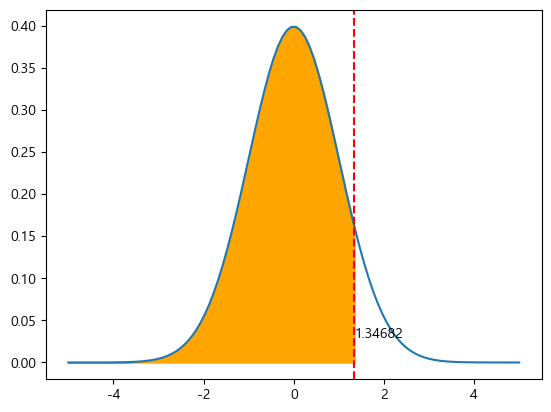

In [16]:
# 표준정규 분포를 이용한 pvalue 도출을 그래프로 설명
col = 'isna_{}'.format(4)
P_var = P_true * (1 - P_true)
n_samples = df_basetable[col].sum()
P_missing_true = df_basetable.loc[df_basetable[col], 'failure'].mean()
P_missing_var = P_var / n_samples
P_missing_std = P_missing_var ** 0.5

stat = (P_missing_true - P_true) / P_missing_std

plt.plot(np.linspace(-5, 5, 100), norm.pdf(np.linspace(-5, 5, 100)))
plt.axvline(stat, color='red', linestyle='--')
plt.text(stat, 0.03, str(stat)[:7])
plt.fill_between(np.linspace(-5, stat, 100), np.zeros(shape=100),
                norm.pdf(np.linspace(-5, stat, 100)), color='orange')

plt.show()

In [17]:
P_true, P_missing_true, stat, norm.cdf(stat)

(0.2114, 0.23755656108597284, 1.3468241702718833, 0.9109815658342959)

In [92]:
from statsmodels.stats.proportion import proportions_ztest
proportions_ztest(
    count = df_basetable.loc[df_basetable['isna_3'], 'failure'].sum(), # positive의 수
    nobs = df_basetable['isna_3'].sum(), # 전체 관측수
    value = P_true, # 귀무가설에서의 비율
    alternative = 'two-sided', # 대립가설의 종류
    prop_var = P_true # 분산 계산시 사용할 비율
)

(-2.905807189028007, 0.0036630709140241546)

참고용 코드입니다.

대립가설이

$H_0: P(failure=True|isna_{4}=True)=0.2114$

$H_1: P(failure=True|isna_{4}=True) > 0.2114$

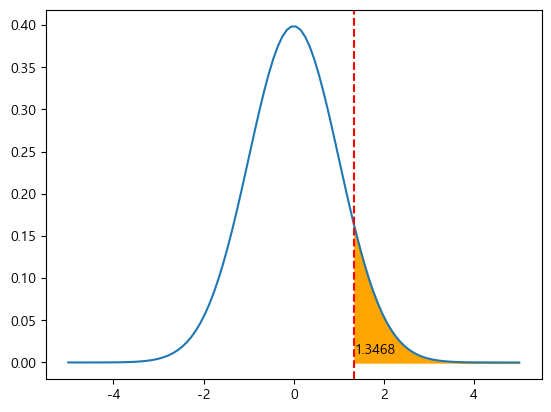

In [19]:
# 표준정규 분포를 이용한 pvalue 도출을 그래프로 설명
col = 'isna_{}'.format(4)
P_var = P_true * (1 - P_true)
n_samples = df_basetable[col].sum()
P_missing_true = df_basetable.loc[df_basetable[col], 'failure'].mean()
P_missing_var = P_var / n_samples
P_missing_std = P_missing_var ** 0.5

stat = (P_missing_true - P_true) / P_missing_std

plt.plot(np.linspace(-5, 5, 100), norm.pdf(np.linspace(-5, 5, 100)))

plt.axvline(stat, color='red', linestyle='--')
plt.text(stat, 0.01, str(stat)[:6])
plt.fill_between(np.linspace(stat, 5, 100), np.zeros(shape=100),
                norm.pdf(np.linspace(stat, 5, 100)), color='orange')

plt.show()

In [20]:
P_true, P_missing_true, stat, 1 - norm.cdf(stat)

(0.2114, 0.23755656108597284, 1.3468241702718833, 0.0890184341657041)

In [21]:
from statsmodels.stats.proportion import proportions_ztest
proportions_ztest(
    count = df_basetable.loc[df_basetable['isna_4'], 'failure'].sum(), # positive의 수
    nobs = df_basetable['isna_4'].sum(), # 전체 관측수
    value = P_true, # 귀무가설에서의 비율
    alternative = 'larger', # 대립가설의 종류
    prop_var = P_true # 분산 계산시 사용할 비율
)

(1.3468241702718833, 0.08901843416570404)

In [94]:
pd.crosstab(index=df_basetable['isna_3'], columns=df_basetable['failure'])

failure,0,1
isna_3,,
False,16654,4492
True,267,45


In [93]:
# 참고용 코드,
# chi2로도 검정해볼 수 있지만, 
# 위와 똑같은 검정은 아닙니다.
# 풀어 봅니다.
from scipy.stats import chi2_contingency
chi2_contingency(
    pd.crosstab(
        index=df_basetable['isna_3'],
        columns=df_basetable['failure']
    ), correction=False # 자유도가 1이라서 영향이 있습니다. 보정을 사용하지 않을 때 위 결과와 가깝습니다.
)

(8.576483165555121,
 0.003405324556499528,
 1,
 array([[16674.96812378,  4471.03187622],
        [  246.03187622,    65.96812378]]))

## 단계 1-2

measuremenet_3을 포함하여 measurement_4 ~ 16까지 위 검정을 반복하고 

귀무가설을 기각할 수 있는 경우의 p-value의 합을 A라고 한다. (유의 수준은 5%로 한다.)

In [97]:
from scipy.stats import norm
# 루프를 이용하여 나머지 변수들도 해봅니다.
A = 0
for i in range(3, 17):
    na_col = 'isna_{}'.format(i)
    P_true = 0.2114
    Var_true = P_true * (1 - P_true) # 모집의 분산
    n_samples = df_basetable[na_col].sum()
    Var_samples = Var_true / n_samples
    P_samples = df_basetable.loc[df_basetable[na_col], 'failure'].mean()
    Z = -abs((P_samples- P_true) / (Var_samples ** 0.5))
    pvalue = norm.cdf(Z) * 2
    if pvalue < 0.05:
        print('*', na_col, n_samples, Var_samples, P_samples, pvalue)
        A += pvalue
    else:
        print(na_col, n_samples, Var_samples, P_samples, pvalue)
A

* isna_3 312 0.0005343270512820513 0.14423076923076922 0.0036630709140241546
isna_4 442 0.00037717203619909505 0.23755656108597284 0.17803686833140808
* isna_5 565 0.00029506201769911503 0.24955752212389382 0.026325008335499278
isna_6 640 0.0002604844375 0.215625 0.793491357072205
isna_7 766 0.00021763712793733682 0.2245430809399478 0.37298091572329806
isna_8 853 0.0001954396717467761 0.20164126611957797 0.48514534123655306
isna_9 989 0.00016856424671385237 0.21840242669362994 0.589649524697301
isna_10 1059 0.00015742213408876299 0.22096317280453256 0.44594047726157915
isna_11 1180 0.00014127969491525423 0.21016949152542372 0.9175464043670771
isna_12 1287 0.00012953383061383063 0.21833721833721834 0.5421744277936988
isna_13 1395 0.00011950540501792115 0.2064516129032258 0.6507952588133231
isna_14 1482 0.00011248990553306344 0.21862348178137653 0.49582912857498873
isna_15 1603 0.00010399877729257642 0.2114784778540237 0.9938599942603648
isna_16 1708 9.760540983606558e-05 0.2066744730679

0.029988079249523434

## 단계 1-3

검정 결과 귀무가설을 기각할 수 있는 경우는 총 두 건이다. 

해당 파생 변수명의 뒷 자리 번호 순으로 na_1, na_2로 파생 변수를 만들어 prob1 데이터셋을 생성하라.

In [98]:
df_prob1 = df_basetable.assign(
    na_1 = lambda x: x['isna_3'],
    na_2 = lambda x: x['isna_5']
)
df_prob1.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,isna_10,isna_11,isna_12,isna_13,isna_14,isna_15,isna_16,isna_17,na_1,na_2
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,False,False,False,False,True,False,False,False,False,False
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,False,False,False,False,False,False,False,False,False,False
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,False,True,False,False,False,False,False,False,False,False
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,False,False,False,False,False,False,False,False,False,False
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,False,False,False,False,False,False,False,False,False,False


In [25]:
A

0.029988079249523434

A의 값을 소수점 넷째 자리에서 반올림하여 셋째 자리까지 출력하시오. 

**0.030**

# 문제 2

첫째는 스프링 개발 업체들은 실험이 제품 별로 공정하게 진행이 됐는지를 의문을 가지고 있다.

product_code에 따라 개발 업체가 다르다. 

product_code에 대해서 스프링에 가한 부하(loading)를 동일하게 했는지 조사하라.

둘째는, attribute_0와 attribute_1은 스프링을 구성하는 주요 소재이다. 

failure와는 관계가 없음이 이전에 검증되었다. 

하지만, 이에 대한 재확인 요청을 받아 attribute_0와 attribute_1은 failure와 상관없음을 확인한다.

이를 위해 다음 단계를 수행하라.


## 단계 2-1

prob1에서 입력 변수 loading에 결측이 없는 행들을 뽑아 prob2 데이터프레임을 만든다.

Hint] prob2의 데이터 수는 21,257 이다.


In [99]:
df_prob2 = df_prob1.loc[df_prob1['loading'].notna()].copy()
df_prob2.shape

(21257, 42)

## 단계 2-2

prob2에 loading의 각 행들에 자연 로그 함수를 적용하여 파생 변수 loading_log를 만든다.


In [100]:
df_prob2['loading_log'] = np.log(df_prob2['loading'])
df_prob2.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,isna_11,isna_12,isna_13,isna_14,isna_15,isna_16,isna_17,na_1,na_2,loading_log
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,False,False,False,True,False,False,False,False,False,4.383276
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,False,False,False,False,False,False,False,False,False,4.441356
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,True,False,False,False,False,False,False,False,False,4.411949
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,False,False,False,False,False,False,False,False,False,4.615813
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,False,False,False,False,False,False,False,False,False,5.236761


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


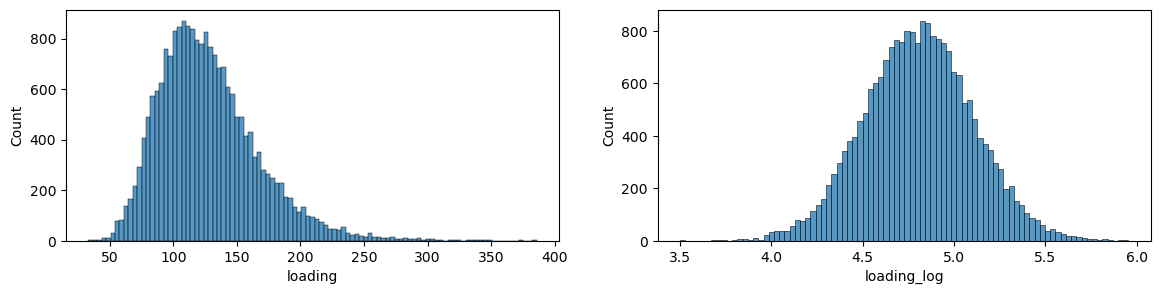

In [101]:
# 로그 변환이 어떤 효과를 보였는지, 보여주기 위한 참고용 코드입니다.
# 좌측으로 치우친 loading 변수가 log 변환을 통해 좌우 대칭형으로 변환되었음을 확인할 수 있습니다.

fig, axes = plt.subplots(1, 2, figsize=(14, 3) )
sns.histplot(data=df_prob2, x='loading', ax=axes[0])
sns.histplot(data=df_prob2, x='loading_log', ax=axes[1])
plt.show()

## 단계 2-3

loading_log가 product_code 각각에 대해서 정규성을 지니고 있는지 확인하고자 한다.

이를 위해 Jarque-Bera로 검정하고 결과의 p-value가 0.05가 넘는 product_code의 수를 B라고 하자.

---

**함수 가이드**

 scipy.stats 에서 제공 기능 활용
 
 문제 지시사항 외 Default 값 사용
 
---


In [102]:
df_prob2['product_code'].unique()

array(['A', 'B', 'C', 'E'], dtype=object)

In [112]:
pd.Series(jarque_bera(df_prob2["loading_log"]), index=["stat", "pvalue"])

stat      3.206504
pvalue    0.201241
dtype: float64

In [118]:
from scipy.stats import jarque_bera

df_prob2.groupby("product_code")["loading_log"]\
    .apply(lambda x: pd.Series(jarque_bera(x), index=["stat", "pvalue"])).unstack()

,stat,pvalue
product_code,,
A,1.467731,0.480050
B,0.616884,0.734591
C,7.536229,0.023096
E,0.048395,0.976093


In [105]:
B = 3
B

3

## 단계 2-4

loading_log 변수를 product_code로 구분했을 때, 

등분산성을 보이는지 Bartlett 검정을 통해 확인한다.

검정 결과에서 p-value를 C라고 한다.

---

**함수 가이드**

 scipy.stats 에서 제공 기능 활용
 
 문제 지시사항 외 Default 값 사용
 
---


In [119]:
# 방법 1: 하드코딩
from scipy.stats import bartlett
result_2_4 = bartlett(
    df_prob2.loc[df_prob2['product_code'] == 'A', 'loading_log'],
    df_prob2.loc[df_prob2['product_code'] == 'B', 'loading_log'],
    df_prob2.loc[df_prob2['product_code'] == 'C', 'loading_log'],
    df_prob2.loc[df_prob2['product_code'] == 'E', 'loading_log'],
)
C = result_2_4.pvalue
result_2_4, C

(BartlettResult(statistic=1.928667047072185, pvalue=0.5873433093297675),
 0.5873433093297675)

In [124]:
df_prob2.groupby('product_code')['loading_log'].agg(list).tolist()

[[4.383275854074314,
  4.441356300749876,
  4.411949448325136,
  4.615813346086571,
  5.236761060848931,
  4.3221439250725044,
  5.085804607589853,
  5.1813340110622175,
  4.695924549256556,
  4.592287560157078,
  4.944210550715014,
  5.16695504835121,
  5.4492342518648975,
  5.0700984573670445,
  5.280713320599676,
  4.667487492052953,
  4.540311613639595,
  4.286616449869223,
  4.456438132187692,
  4.693547296605504,
  4.860509835518618,
  4.408668565620303,
  5.047417138188784,
  4.771701056875722,
  4.609958702719888,
  4.57295686362344,
  5.408784819574008,
  4.853357507741732,
  4.533244446416503,
  4.516338972281476,
  5.353941270296033,
  4.6290820060344045,
  5.1591702351378785,
  5.2295566109772444,
  4.105284502260435,
  5.207900196423574,
  4.74005066818191,
  4.477336814478207,
  4.639474989680082,
  4.970854424084411,
  4.914784968439421,
  4.930220294908611,
  4.585069514281089,
  5.186323789587112,
  5.253215392635616,
  5.352805551832106,
  5.102728182753178,
  5.37087

In [125]:
# 방법 2: GroupBy + unpacking
# list는 iterable을 대상으로 List 콘테이너를 만들어주는 함수라고 할 수 있습니다. 
# agg에 list를 전달하여 product_code별로 loading_log에 대한 List를 만들어주도록 합니다.
# agg를 거치면 product_code 별로 loading_log의 리스트가 담긴 Series가 만들어 집니다. 
# tolist()를 하면 이 4개의 List를 담은 하나의 List가 생성됩니다.
# * List unpacking 연산자입니다. 하나의 리스트로 담긴 4개의 List를 풀어 bartlett에 전달합니다.
result_2_4 = bartlett(
    *df_prob2.groupby('product_code')['loading_log'].agg(list).tolist()
)
C = result_2_4.pvalue
result_2_4, C

(BartlettResult(statistic=1.928667047072185, pvalue=0.5873433093297675),
 0.5873433093297675)

## 단계 2-5

product_code에 대한 분산분석(ANOVA)을 통해서 loading_log 평균에 차이가 있는지 검정한다.

그 결과 중 p-value를 D라고 한다.

---

**함수 가이드**

 scipy.stats 제공 기능 활용
 
 문제 지시사항 외 Default 값 사용
 
---


In [34]:
from scipy.stats import f_oneway
result_2_5 = f_oneway(
    *df_prob2.groupby('product_code')['loading_log'].agg(list).tolist()
)
D = result_2_5.pvalue
result_2_5, D 

(F_onewayResult(statistic=0.37177284134760413, pvalue=0.7733782072320899),
 0.7733782072320899)

In [35]:
# 참고용: statsmodels을 통한 oneway-ANOVA입니다.
# 값에 아주 미묘한 차이가 보입니다.
# 따라서 완전히 같은 방법이라고 볼 수 없으니, 
# 가이드에서 제공한 방법을 따라 가는 것을 권유드립니다.
from statsmodels.formula.api import ols
from statsmodels.api import stats as ss

# C에 값이 설정 되어 있다면 
C_ = C
del C
lm = ols('loading_log ~ C(product_code)', data=df_prob2).fit()
ss.anova_lm(lm).loc['C(product_code)', 'PR(>F)']
C = C_

## 단계 2-6

Chi-square 검정을 통해 attribute_0, attribute_1의 결합값이 failure와 연관이 있는지 조사하라. 

attribute_0, attribute_1의 결합값의 의미 attribute_0=material_7, attribute_1=material_8 이라면, 이 둘의 결합값은
matertial_7material_8를 의미한다.

(유의 수준 1%) 연관이 있다면 E값은 1 없으면 0으로 한다.

---

**함수 가이드**

 scipy.stats.chi2_contingency, correction=False
 
 문제 지시사항 외 Default 값 사용
 
---


In [132]:
df_prob2["attribute_0"].value_counts(), df_prob2["attribute_1"].value_counts()

(material_7    16048
 material_5     5209
 Name: attribute_0, dtype: int64,
 material_8    10767
 material_6     5281
 material_5     5209
 Name: attribute_1, dtype: int64)

In [137]:
df_prob2['attribute_0'] + df_prob2['attribute_1']

id
0        material_7material_8
1        material_7material_8
2        material_7material_8
3        material_7material_8
4        material_7material_8
                 ...         
26565    material_7material_6
26566    material_7material_6
26567    material_7material_6
26568    material_7material_6
26569    material_7material_6
Length: 21257, dtype: object

In [142]:
from scipy.stats import chi2_contingency

cont_tb = pd.crosstab(index=df_prob2['attribute_0'] + df_prob2['attribute_1'], columns=df_prob2["failure"])
cont_tb

chi2_contingency(cont_tb, correction=False)  # 자유도 (3-1)*(2-1)=2 이므로 correction=False


(7.0400463075335615,
 0.029598749837407304,
 2,
 array([[4106.03584702, 1102.96415298],
        [4162.79042198, 1118.20957802],
        [8487.17373101, 2279.82626899]]))

In [36]:
from scipy.stats import chi2_contingency
result_2_6 = chi2_contingency(
    pd.crosstab(
        index=df_prob2['attribute_0'] + df_prob2['attribute_1'],
        columns=df_prob2['failure']
    ),
    correction=False
)
# 귀무가설 받아들입니다. 독립입니다. -> 연관성이 없다.
E = 0
result_2_6, E

((7.0400463075335615,
  0.029598749837407304,
  2,
  array([[4106.03584702, 1102.96415298],
         [4162.79042198, 1118.20957802],
         [8487.17373101, 2279.82626899]])),
 0)

In [37]:
B, C, D, E, B + C + D + E

(3, 0.5873433093297675, 0.7733782072320899, 0, 4.360721516561858)

B + C + D + E의 값을 소수점 셋째 자리에서 반올림하여 둘째 자리까지 출력하시오.

**4.36**

In [143]:
# python 반올림 내장 함수의 한계: floating point에 대한 정확한 처리를 할 수 없다는 계산상 한계로 인해 
# round는 때에 따라서, 의도한 연산 결과를 얻지 못할 수 있습니다.
round(2.65, 1), round(2.75, 1), round(2.675, 2), round(2.685, 2)

(2.6, 2.8, 2.67, 2.69)


# 문제 3

로지스틱 회귀모델로 수치형 변수 measurement_0 ~ 17, 

loading과 이진형인 na_1, na_2 중에서 최적의 성능을 보이는 입력 변수들을 찾고자 한다.


## 단계 3-1

prob1을 복사하여 prob3을 만든다. loading의 결측치는 loading의 평균으로 대치한다.  

In [147]:
# assign을 통해 값 대입과 동시에 deep copy를 합니다.
df_prob3 = df_prob1.assign(
    loading=lambda x: x['loading'].fillna(x['loading'].mean())
)
df_prob3['loading'].isna().sum()

0

## 단계 3-2: 
    
prob3를 80%는 학습데이터 prob3_train으로 20%는 테스트데이터 prob3_test로 나눈다. 

prob3_train의 failure가 1인 비율과 prob3_test의 failure가 1의 비율을 동일하게 한다.


---

**함수 가이드**

 sklearn.model_selection.train_test_split, random_state=123, 
 
 train과 test의 failure의 비율은 stratify 매개 변수를 이용하여 맞춘다.
 
 문제 지시사항 외 Default 값 사용
 
---

In [148]:
from sklearn.model_selection import train_test_split

# stratify를 통해 train / test의 failure의 비율을 같게하여 나누는 방법입니다.
df_prob3_train, df_prob3_test = train_test_split(df_prob3, train_size=0.8, random_state=123, stratify=df_prob3['failure'])
df_prob3_train, df_prob3_test = df_prob3_train.copy(), df_prob3_test.copy()

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision

In [149]:
# 참고코드입니다. 위와 로직이 다릅니다.
# 다른방법으로 비율이 동일하게 구분해봅니다.
# failure로 구분했을 때, 각각에 대해서 첫번째과 두번째는 train으로 세번째는 test로, 네번째, 다섯번째는 train, 여섯 번째는 test로 ...
# 구분합니다
# 즉, failure 각각에 대해 처음에 0부터 길이-1까지만큼 순차적으로 번호를 메겨 3 나누어서 나머지가 2이면 test, 아니면 train으로 
# 구분합니다.

# failure 별로 처음 4개씩만 봅니다.
# failure가 0일 때, id가 0, 1, 3 train, 2는 test, ..., failure가 1 일 때는 6, 7, 13 train, 11 test, ...
df_prob3.groupby('failure').apply(lambda x: x.iloc[:4])

product_code  loading attribute_0 attribute_1  attribute_2  \
failure id                                                              
0       0             A    80.10  material_7  material_8            9   
        1             A    84.89  material_7  material_8            9   
        2             A    82.43  material_7  material_8            9   
        3             A   101.07  material_7  material_8            9   
1       6             A   161.71  material_7  material_8            9   
        7             A   177.92  material_7  material_8            9   
        11            A   175.38  material_7  material_8            9   
        13            A   159.19  material_7  material_8            9   

            attribute_3  measurement_0  measurement_1  measurement_2  \
failure id                                                             
0       0             5              7              8              4   
        1             5             14              3              3   
        2             5             12              1              5   
        3             5             13              2              6   
1       6             5             12              2              4   
        7             5              4              8              8   
        11            5              7              3              2   
        13            5              6              9             10   

            measurement_3  ...  isna_10  isna_11  isna_12  isna_13  isna_14  \
failure id                 ...                                                
0       0          18.040  ...    False    False    False    False     True   
        1          18.213  ...    False    False    False    False    False   
        2          18.057  ...    False     True    False    False    False   
        3          17.295  ...    False    False    False    False    False   
1       6          17.303  ...    False    False    False    False    False   
        7          17.062  ...    False    False    False    False    False   
        11         17.029  ...    False    False    False    False    False   
        13         19.710  ...    False    False    False    False    False   

            isna_15  isna_16  isna_17   na_1   na_2  
failure id                                           
0       0     False    False    False  False  False  
        1     False    False    False  False  False  
        2     False    False    False  False  False  
        3     False    False    False  False  False  
1       6      True    False    False  False  False  
        7     False    False    False  False  False  
        11    False    False    False  False  False  
        13    False    False    False  False  False  

[8 rows x 42 columns]

In [150]:
df_prob3_test_ = df_prob3.loc[df_prob3.groupby('failure').apply(
    lambda x: pd.DataFrame(np.arange(0, len(x)) % 3 == 2, index=x.index, columns=['is_test'])
)['is_test']]
df_prob3_train_ = df_prob3.loc[df_prob3.groupby('failure').apply(
    lambda x: pd.DataFrame(np.arange(0, len(x)) % 3 != 2, index=x.index, columns=['is_train'])
)['is_train']]

## 단계 3-3

prob3_train의 수치형 입력 변수 loading, measurement_0 ~ 17을 표준화한다. 

prob3_train의 표준화 설정으로 prob3_test의 loading, measurement_0 ~ 17에도 적용한다. 

표준화 처리한 prob3_train과 prob3_test는 문제 4와 문제 5에서 사용한다.


---

**함수 가이드**

 sklearn.preprocessing 제공 기능 활용, 
 
 문제 지시사항 외 Default 값 사용
 
---


In [151]:
from sklearn.preprocessing import StandardScaler
X_std = ['loading'] + ['measurement_{}'.format(i) for i in range(18)]
std_scaler = StandardScaler()
df_prob3_train[X_std] = std_scaler.fit_transform(df_prob3_train[X_std])
df_prob3_test[X_std] = std_scaler.transform(df_prob3_test[X_std])

## 단계 3-4
    
로지스틱 회귀모델을 사용하여 loading, measurement_0~17과 na_1, na_2를 입력 변수로 하여 prob3_train을 학습한다. 

로지스틱 회귀모델을 prob3_test로 성능을 측정한 값을 A라고 한다.

입력 변수: loading, measurement_0~17, na_1, na_2

대상 변수: failure

성능 지표: AUC(area under of ROC curve)

---

**함수 가이드**

 sklearn.linear_model.LogisticRegression, solver='lbfgs', 문제 지시사항 외 Default 값 사용
 
 sklearn.metrics.roc_auc_score
 
---

In [44]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

# 입력 변수르 정리합니다.
X_lr = ['loading'] + ['measurement_{}'.format(i) for i in range(18)] + ['na_1', 'na_2']
# 로지스틱 회귀모델을 만듭니다.
clf_lr = LogisticRegression(solver='lbfgs')
# 모델을 학습합니다.
clf_lr.fit(df_prob3_train[X_lr], df_prob3_train['failure'])
roc_auc_score(df_prob3_train['failure'], 
              clf_lr.predict_proba(df_prob3_train[X_lr])[:, 1])

0.5952982435574312

In [45]:
A = roc_auc_score(df_prob3_test['failure'], 
              clf_lr.predict_proba(df_prob3_test[X_lr])[:, 1])
A

0.5792951262053387

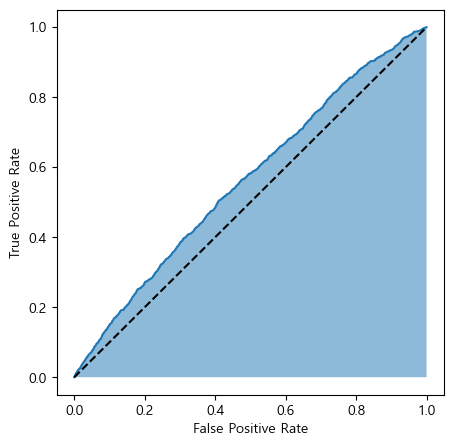

In [46]:
# 참고 코드 입니다. ROC curve 그리기

df_roc = pd.DataFrame({'prob': clf_lr.predict_proba(df_prob3_test[X_lr])[:, 1],
 'label': df_prob3_test['failure']})
df_roc.sort_values('prob', ascending=False, inplace=True) # Positive 확률에 따른 False Positive 수를 구하기 위해 정렬
df_roc['fp'] = df_roc['label'].cumsum() # Positive 확률까지의 누적 False Positive 수
df_roc = df_roc['fp'].value_counts().sort_index().cumsum().reset_index() # False Positive에 따른 True Positive 수를 구한다.
df_roc.columns = ['tp', 'fp']
df_roc['fp'] = df_roc['fp'].shift(1).fillna(0) # shift를 해야만 False Positive 따른 True Positive 수가 맞춰진다.
df_roc['tpr'] = df_roc['tp'] / df_roc['tp'].iloc[-1] # Rate로 환산, 마지막 수는 True의 수이다.
df_roc['fpr'] = df_roc['fp'] / df_roc['fp'].iloc[-1] # Rate로 환산, 마지막 수는 False의 수이다.

plt.figure(figsize=(5, 5))
plt.plot(df_roc['fpr'], df_roc['tpr'])
plt.fill_between(df_roc['fpr'], df_roc['tpr'], np.zeros_like(df_roc['tpr']), alpha=0.5)
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## 단계 3-5

loading, measurement_0 ~ 17, na_1, na_2를 후보 입력 변수로 한다. 

전진 선택법을 사용하여 이 후보 입력 변수 중에서 최적의 성능을 보이는 입력 변수의 조합을 찾는다. 

전진 선택법의 선택 기준은 prob3_train을 대상으로 5겹 층화교차검증(5-Fold stratified cross validation)을 하고 

겹외(OOF, Out-Of Fold) 성능의 평균값으로 한다. 전진 선택 과정에서 선택했던 변수를 제외하지 않는다. 

입력 변수: 본 단계 요건 참고

대상 변수: failure 

성능 지표: AUC(area under of ROC curve)

---
**함수가이드**

mlxtend.feature_selection.SequentialFeatureSelector

sklearn.linear_model.LogisticRegression, solver='lbfgs'

sklearn.metrics.roc_auc_score

sklearn.model_selection.StratifiedKFold, random_state=123, shuffle=True

문제 지시사항 외 Default 값 사용

---

In [47]:
# joblib 관련 warning이 뜹니다.
# 임시로 warning을 회피하는 로직을 추가합니다.
import warnings
with warnings.catch_warnings(): 
    warnings.simplefilter("ignore")
    from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import StratifiedKFold

X_sfs = ['loading'] + ['measurement_{}'.format(i) for i in range(18)] + ['na_1', 'na_2']
sfs = SequentialFeatureSelector(
    estimator = LogisticRegression(solver='lbfgs'), # Wrapper를 설정합니다.
    k_features = 'best', # 후보 입력 변수 중에서 최적의 성능을 보이는 입력 변수의 조합을 찾는다.
    forward=True, # 전진 선택법을 사용합니다.
    floating=False, # 선택했던 변수를 제외하지 않는다.
    scoring='roc_auc', # 지표를 정의합니다.
    cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True) # 5겹 층화교차검증(5-Fold stratified cross validation)
)
sfs.fit(df_prob3_train[X_sfs], df_prob3_train['failure'])

SequentialFeatureSelector(clone_estimator=True,
                          cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                          estimator=LogisticRegression(C=1.0, class_weight=None,
                                                       dual=False,
                                                       fit_intercept=True,
                                                       intercept_scaling=1,
                                                       l1_ratio=None,
                                                       max_iter=100,
                                                       multi_class='warn',
                                                       n_jobs=None,
                                                       penalty='l2',
                                                       random_state=None,
                                                       solver='lbfgs',
                                                       tol=0.0001, 

In [48]:
# sfs.subsets_ 자세한 수행 결과가 기록되어있습니다.
sfs.k_feature_names_, sfs.k_score_

(('loading',
  'measurement_1',
  'measurement_4',
  'measurement_14',
  'measurement_17',
  'na_1'),
 0.5917537024093409)

In [49]:
# 가장 좋은 결과를 낸 입력 변수의 조합을 남깁니다.
X_lr_best = list(sfs.k_feature_names_)
X_lr_best

['loading',
 'measurement_1',
 'measurement_4',
 'measurement_14',
 'measurement_17',
 'na_1']

## 단계 3-6

단계 3-5에서 찾은 최적의 입력 변수 조합으로 로지스틱 회귀모델을 사용하여 prob3_train을 학습하고 

prob3_test로 성능을 측정한 값을 B라고 한다.

입력 변수: **단계 3-5**에서 도출한 최적의 입력 변수 조합

대상 변수: failure

성능 지표: AUC(area under of ROC curve)

---
**함수 가이드**

sklearn.linear_model.LogisticRegression, solver='lbfgs'

sklearn.metrics.roc_auc_score

문제 지시사항 외 Default 값 사용

---

In [50]:
from sklearn.linear_model import LogisticRegression
clr_lr = LogisticRegression(solver='lbfgs')
clf_lr.fit(df_prob3_train[X_lr_best], df_prob3_train['failure'])
roc_auc_score(df_prob3_train['failure'], 
              clf_lr.predict_proba(df_prob3_train[X_lr_best])[:, 1])

0.5936682060775388

In [51]:
B = roc_auc_score(df_prob3_test['failure'], 
              clf_lr.predict_proba(df_prob3_test[X_lr_best])[:, 1])
B

0.5838326230092876

In [52]:
A, B, A - B

(0.5792951262053387, 0.5838326230092876, -0.004537496803948882)

A-B값을 소수점 넷째 자리에서 반올림하여 셋째 자리까지 출력하시오

**-0.005**


# 문제 4

차원 축소 기법을 통한 데이터의 특성과 failure 분류 성능을 높힐 만한 요소를 살펴 본다. 

첫째로, loading을 제외하고, measurement_0 ~ 17을 입력으로 failure를 대상 변수로 Linear Discrimant Analysis(LDA) 모델을 만든다. 

범주가 두 개인 failure를 분류한다는 점에서 LDA 모델은 measurement_0 ~ 17를 한 개의 경계점으로 

failure를 최대한 정확하게 구분하도록 하나의 연속형 변수로 변환한다. 

실험 대상의 내구력을 나타낸다고 할 수 있는 LDA 변환값과 

실험에서 스프링에 가한 부하(loading)와 상관도를 측정하여, 

스프링에 따라 부하(loading)를 조정한 정도를 살펴본다.

둘째로, PCA를 사용하여 차원 감소로 failure 분류 성능에 얼마나 효과가 있을지 살펴본다.

문제3에서 사용했던, 전처리(loading 결측치 처리와 표준화 과정을 거친) 과정을 거친 prob3_train과 prob3_test를 사용한다.


## 단계 4-1

prob3_train에서 measurement_0 ~ 17을 입력으로 failure를 대상 변수로 하여 LDA(Linear Discriminant Analysis) 모델을 학습한다. 

measurement_0 ~ 17에 대한 LDA의 변환값과 loading과 스피어만 상관도 (spearman correlation)의 p-value를 구하여 A라고 한다.

입력 변수] measurement_0 ~ 17 (순서에 유의 하시오)

대상 변수] failure

---
**함수가이드**

sklearn.discriminant_analysis 제공 기능 활용

scipy.stats.spearmanr

문제 지시사항 외 Default 값 사용

---

In [53]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import spearmanr
# 별다른 요건이 제시된 것이 없습니다.
# Default를 사용하시면 됩니다.
lda = LinearDiscriminantAnalysis()
X_lda = ['measurement_{}'.format(i) for i in range(18)]
lda.fit(df_prob3_train[X_lda], df_prob3_train['failure'])
# transform을 통해 투영값(변환값)을 얻을 수 있습니다. 
A = spearmanr(df_prob3_train['loading'], lda.transform(df_prob3_train[X_lda])[:, 0]).pvalue
A

0.6995009550811424

## 단계 4-2

prob3_train에서 measurement_0 ~ 17을 대상으로 주성분분석(Principal Component Analysis, PCA) 모델을 학습한다. 

분산 설명율이 높은 순으로 주성분을 변수명을 pca_0 ~ 17하여 prob3_train에 추가하여 prob4_train을 만든다. 

prob3_test에 prob3_train를 학습했던 PCA 모델로 동일한 방법으로 pca0 ~17 파생 변수를 추가하여 prob4_test를 만든다.

입력 변수] measurement_0 ~ 17 (순서에 유의 하시오)

---
**함수가이드**

sklearn.decomposition.PCA, random_state=123

문제 지시사항 외 Default 값 사용

---


In [54]:
from sklearn.decomposition import PCA
# PCA 모델 설정시 n_components 가 0~1 사이의 실수인 경우
# n_components 만큼의 변동성 이상을 설명하는데 필요한 최소의 컴포넌트를 반환토록합니다.
# n_components 가 1이상의 자연수 이면 n_components 만큼 컴포넌트를 반환토록합니다.
# n_components 가 설정이 되어 있지 않으면 모든 컴포넌트를 반환합니다.
pca = PCA(random_state=123)
X_pca = ['measurement_{}'.format(i) for i in range(18)]
df_prob4_train = df_prob3_train.copy()
# pca.fit_transform 또는 transform은 2차원(데이터수 x 컴포넌트) np.array를 반환합니다.
# 2차원 array를 pd.DataFrame에 넣어주려면
# 데이터프레임 형식으로 되어 있어야 합니다. 
# numpy array에서 DataFrame으로 변환하여 파생변수로 넣어 줄 때, 아래와 같이 index를 맞춰줘야합니다.
df_prob4_train[['pca_{}'.format(i) for i in range(18)]] = \
        pd.DataFrame(pca.fit_transform(df_prob3_train[X_pca]), index= df_prob4_train.index)
df_prob4_test = df_prob3_test.copy()
df_prob4_test[['pca_{}'.format(i) for i in range(18)]] = \
        pd.DataFrame(pca.transform(df_prob3_test[X_pca]), index= df_prob4_test.index)
(
    df_prob4_train[['pca_{}'.format(i) for i in range(18)]].isna().sum().sum(), 
    df_prob4_test[['pca_{}'.format(i) for i in range(18)]].isna().sum().sum()
)

(0, 0)

## 단계 4-3

초기에 loading을 입력 변수로 하여 prob4_train을 학습하고, prob4_test에 대한 성능을 측정한다.

여기에 pca_0에서 pca_17까지 입력 변수를 하나씩 추가 하면서, 

즉 분산 설명율이 높은 순으로 컴포넌트를 하나씩 추가하여 prob4_train를 학습하고 prob4_test의 성능을 측정 했을 때, 

최적의 성능을 보인 컴포넌트들의 분산 설명율의 합을 B라고 한다. (만일 없다면 B = 0이다.)

입력 변수: 설명 참고

대상 변수: failure

성능 지표: AUC(area under of ROC curve)

---
**함수가이드**

sklearn.linear_model.LogisticRegression, solver=’lbfgs’

---

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
# 초기 성능을 구합니다.
X_inp = ['loading']
clf_lr = LogisticRegression(solver ='lbfgs')
clf_lr.fit(df_prob4_train[X_inp], df_prob4_train['failure'])
best_score = roc_auc_score(df_prob4_test['failure'], clf_lr.predict_proba(df_prob4_test[X_inp])[:, 1])
# reference가 아닌 내용이 입력되도록합니다.
X_best = X_inp.copy()
for i in range(18):
    X_inp.append('pca_{}'.format(i))
    clf_lr.fit(df_prob4_train[X_inp], df_prob4_train['failure'])
    score = roc_auc_score(df_prob4_test['failure'], clf_lr.predict_proba(df_prob4_test[X_inp])[:, 1])
    if score > best_score:
        X_best = X_inp.copy()
        best_score = score
    print(i, score, X_best, best_score)
X_best, best_score

0 0.579565141627812 ['loading', 'pca_0'] 0.579565141627812
1 0.5784170060859327 ['loading', 'pca_0'] 0.579565141627812
2 0.5786498903164131 ['loading', 'pca_0'] 0.579565141627812
3 0.5801256923420173 ['loading', 'pca_0', 'pca_1', 'pca_2', 'pca_3'] 0.5801256923420173
4 0.5805735466314028 ['loading', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4'] 0.5805735466314028
5 0.5811103203542446 ['loading', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5'] 0.5811103203542446
6 0.581757510516433 ['loading', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6'] 0.581757510516433
7 0.5808025223153578 ['loading', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6'] 0.581757510516433
8 0.5801787834323228 ['loading', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6'] 0.581757510516433
9 0.5801664063683251 ['loading', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6'] 0.581757510516433
10 0.5794231311040503 ['loading', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_

(['loading', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6'],
 0.581757510516433)

In [56]:
B = np.sum(pca.explained_variance_ratio_[:7])
B

0.49053704530610653

In [57]:
A, B, A + B

(0.6995009550811424, 0.49053704530610653, 1.1900380003872488)

A + B를 소수점 셋째 자리에서 반올림하여 둘째 자리까지 구하라.

**1.19**

# 문제 5

랜덤포레스트 분류기(Random-Forest Classifier)의 최적의 하이퍼 파라미터(Hyper-Parameter, 초매개변수)를 탐색하고자 한다.

문제3에서 사용했던, 전처리(loading 결측치 처리와 표준화 과정을 거친) 과정을 거친 prob3_train과 prob3_test를 사용한다.

## 단계 5-1

sklearn에서 제공하는 랜덤포레스트 분류기(Random-Forest Classifier)의 하이퍼 파라미터 중 

n_estimators, max_depth 그리고 min_samples_split의 최적 조합을 탐색한다. 

탐색 값은 아래에 제공한 하이퍼 파라미터의 모든 조합이다. 

prob3_train을 대상으로 5-겹 층화교차검증(5-fold stratified cross validation)으로 

각각 층의 겹외셋(OOF set, Out-Of-Fold set)의 성능에 대한 평균을 기준으로 하이퍼 파라미터를 선택한다.

  - n_estimators: [5, 10, 15]

  - max_depth: [5, 6, 7]
  
  - min_samples_split: [256, 512]

Hint] 모든 하이퍼 파라미터의 조합의 수는 18개이다

입력 변수: loading, measurement_0 ~ 17, na_1, na_2 (순서에 유의)

대상 변수: failure

성능 지표: AUC (area under of ROC curve)

---
**함수가이드**

sklearn.ensemble.RandomForestClassifier, random_state=123 

itertools.product 필요시 사용

sklearn.model_selection.cross_val_score 필요시 사용

sklearn.model_selection.StratifiedKFold, random_state=123, shuffle=True

sklearn.model_selection.GridSearchCV 필요시 사용

---

In [152]:
# 방법 1: GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
# 
gscv = GridSearchCV(
    estimator=RandomForestClassifier(random_state=123), # Hyper Parameter 탐색할 모델을 세팅합니다. 
    param_grid={
        'n_estimators': [5, 10, 15],
        'max_depth': [5, 6, 7],
        'min_samples_split': [256, 512]
    }, # dict 형식으로 param_grid를 정의합니다. key: 대상 Hyper Parameter, value: 후보 설정값 (List)
    scoring='roc_auc', # _score로 끝나면 _score를 빼고 넘기고, _error끝나면 neg_를 앞에 붙입니다, ex: neg_mean_squared_error,
    cv =StratifiedKFold(n_splits=5, random_state=123, shuffle=True), # 5겹 층화교차검증을 정의합니다. 
    iid = False # 단순평균을 사용합니다. True면 겹외셋의 수에 따라 가중평균으로 구합니다.
)
X_gscv = ['loading'] + ['measurement_{}'.format(i) for i in range(18)] + ['na_1', 'na_2']
gscv.fit(df_prob3_train[X_gscv], df_prob3_train['failure'])
# cv_results_에는 상세 결과가 들어가 있습니다.
best_param, best_score = gscv.best_params_, gscv.best_score_
best_param, best_score

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `n

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the p

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: Depreca

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated a

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the p

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: Depreca

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated a

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the p

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: Depreca

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated a

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

({'max_depth': 7, 'min_samples_split': 512, 'n_estimators': 15},
 0.5732755537421365)

In [155]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df_prob3_train['failure'], gscv.predict_proba(df_prob3_train[X_gscv])[:, 1])

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):


0.640831357172629

In [156]:
roc_auc_score(df_prob3_test['failure'], gscv.predict_proba(df_prob3_test[X_gscv])[:, 1])

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):


0.5709976076438141

In [59]:
# 방법 2: 반복문
# itertools의 product를 이용하여 반복문을 간단히 만듭니다. 그냥 3중 반복문을 써도 되긴합니다.

import itertools
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score

# make_scorer를 통해 측정 지표를 정의해 봅니다.
# roc_auc_score는 확률기반 지표이므로, needs_proba=True로 설정합니다.
# Ex) 평균 산정방식을 micro로 하는 roc_auc 지표정의 (multi-class일 경우 산정방식 정의 필요)
#     make_scorer(roc_auc_score, needs_proba=True, average='micro')
# 이 문제에서는 아래와 같이 정의합니다.
my_scorer = make_scorer(roc_auc_score, needs_proba=True)

cnt = 0
best_score, best_param = 0, None # 초기 설정입니다(가장 않좋은 성능을 세팅합니다)
X_gscv = ['loading'] + ['measurement_{}'.format(i) for i in range(18)] + ['na_1', 'na_2']
for n_estimators, max_depth, min_samples_split in itertools.product([5, 10, 15], [5, 6, 7], [256, 512]):
    cnt += 1
    param = {
        'n_estimators': n_estimators, 
        'max_depth': max_depth, 
        'min_samples_split': min_samples_split,
    } # 재사용할 수 있도록 dict로 만듭니다.
    estimator = RandomForestClassifier(**param, random_state=123) # dict. unpacking을 통해 parameter를 전달합니다.
    scores_ = cross_val_score(
        estimator, df_prob3_train[X_gscv], df_prob3_train['failure'], 
        cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
        scoring=my_scorer # 위에서 정의한 지표로 넘깁니다. == 'roc_auc'와 똑같은 설정입니다.
    )
    score = np.mean(scores_)
    if best_score < score:
        best_score = score
        best_param = param
    print(cnt, n_estimators, max_depth, min_samples_split, scores_, score)
best_score, best_param

1 5 5 256 [0.55772586 0.52999849 0.56252283 0.54878867 0.57452188] 0.5547115468443294
2 5 5 512 [0.57327539 0.53169036 0.57488874 0.55001878 0.57870194] 0.5617150416141751
3 5 6 256 [0.56223118 0.54107909 0.55498219 0.5565036  0.56970374] 0.5568999583940097
4 5 6 512 [0.57493357 0.53551755 0.57316762 0.55214722 0.575854  ] 0.5623239919998733
5 5 7 256 [0.55355904 0.52359432 0.57118851 0.56068111 0.57479385] 0.5567633668997499
6 5 7 512 [0.56125001 0.53852246 0.57968805 0.55914775 0.58239937] 0.5642015275666604
7 10 5 256 [0.57576266 0.53750454 0.57111448 0.55096215 0.59193235] 0.5654552370913933
8 10 5 512 [0.58392692 0.54268624 0.58178343 0.55494504 0.59039568] 0.5707474621000601
9 10 6 256 [0.57547528 0.55040574 0.57098829 0.55392916 0.58985988] 0.5681316681217556
10 10 6 512 [0.58452661 0.54046722 0.57541997 0.55061894 0.58939099] 0.5680847464819798
11 10 7 256 [0.5721083  0.54050513 0.57885077 0.55877299 0.58489036] 0.5670255107788329
12 10 7 512 [0.57735269 0.54476609 0.58344731 0

(0.5745226991354744,
 {'n_estimators': 15, 'max_depth': 7, 'min_samples_split': 512})

## 단계 5-2

단계 5-1에서 구한 최적 하이퍼 파라미터로 설정한 랜덤포레스트 분류기(Random-Forest Classifier)를 사용하여 prob3_train 학습하고, 

prob3_test로 성능을 측정하여 이 값을 A라고 한다.

입력 변수: loading, measurement_0 ~ 17, na_1, na_2 (순서에 유의)

대상 변수: failure

성능 지표: AUC (area under of ROC curve)

---
**함수가이드**

sklearn.ensemble.RandomForestClassifier, random_state=123 

---


In [157]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

clf_rf = RandomForestClassifier(**best_param, random_state=123)
X_gscv = ['loading'] + ['measurement_{}'.format(i) for i in range(18)] + ['na_1', 'na_2']
clf_rf.fit(df_prob3_train[X_gscv], df_prob3_train['failure'])
roc_auc_score(df_prob3_train['failure'], clf_rf.predict_proba(df_prob3_train[X_gscv])[:, 1])

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: Depreca

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the p

0.640831357172629

In [158]:
A = roc_auc_score(df_prob3_test['failure'], clf_rf.predict_proba(df_prob3_test[X_gscv])[:, 1])
A

/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/home/heesandv/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):


0.5709976076438141

A값을 소수점 넷째 자리에서 반올림하여 3째 자리까지 출력하시오.

**0.569**